<a href="https://colab.research.google.com/github/aryan-anil/VIT/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary


try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 38.13 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


# **Create train and test DataLoaders**

In [ ]:
from going_modular.going_modular import data_setup

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = transform, # use manually created transforms
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names   # 8 batches for train & 3 batches for test

(8, 3, ['pizza', 'steak', 'sushi'])

# **Visualize an image**

In [ ]:
# Get a batch from train
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

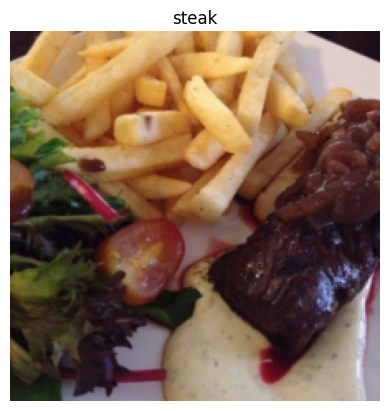

In [ ]:
plt.imshow( image.permute(1, 2, 0)) # pass in an [H, W, C] for matplotlib
plt.title(class_names[label])
plt.axis(False)

#**ViT**

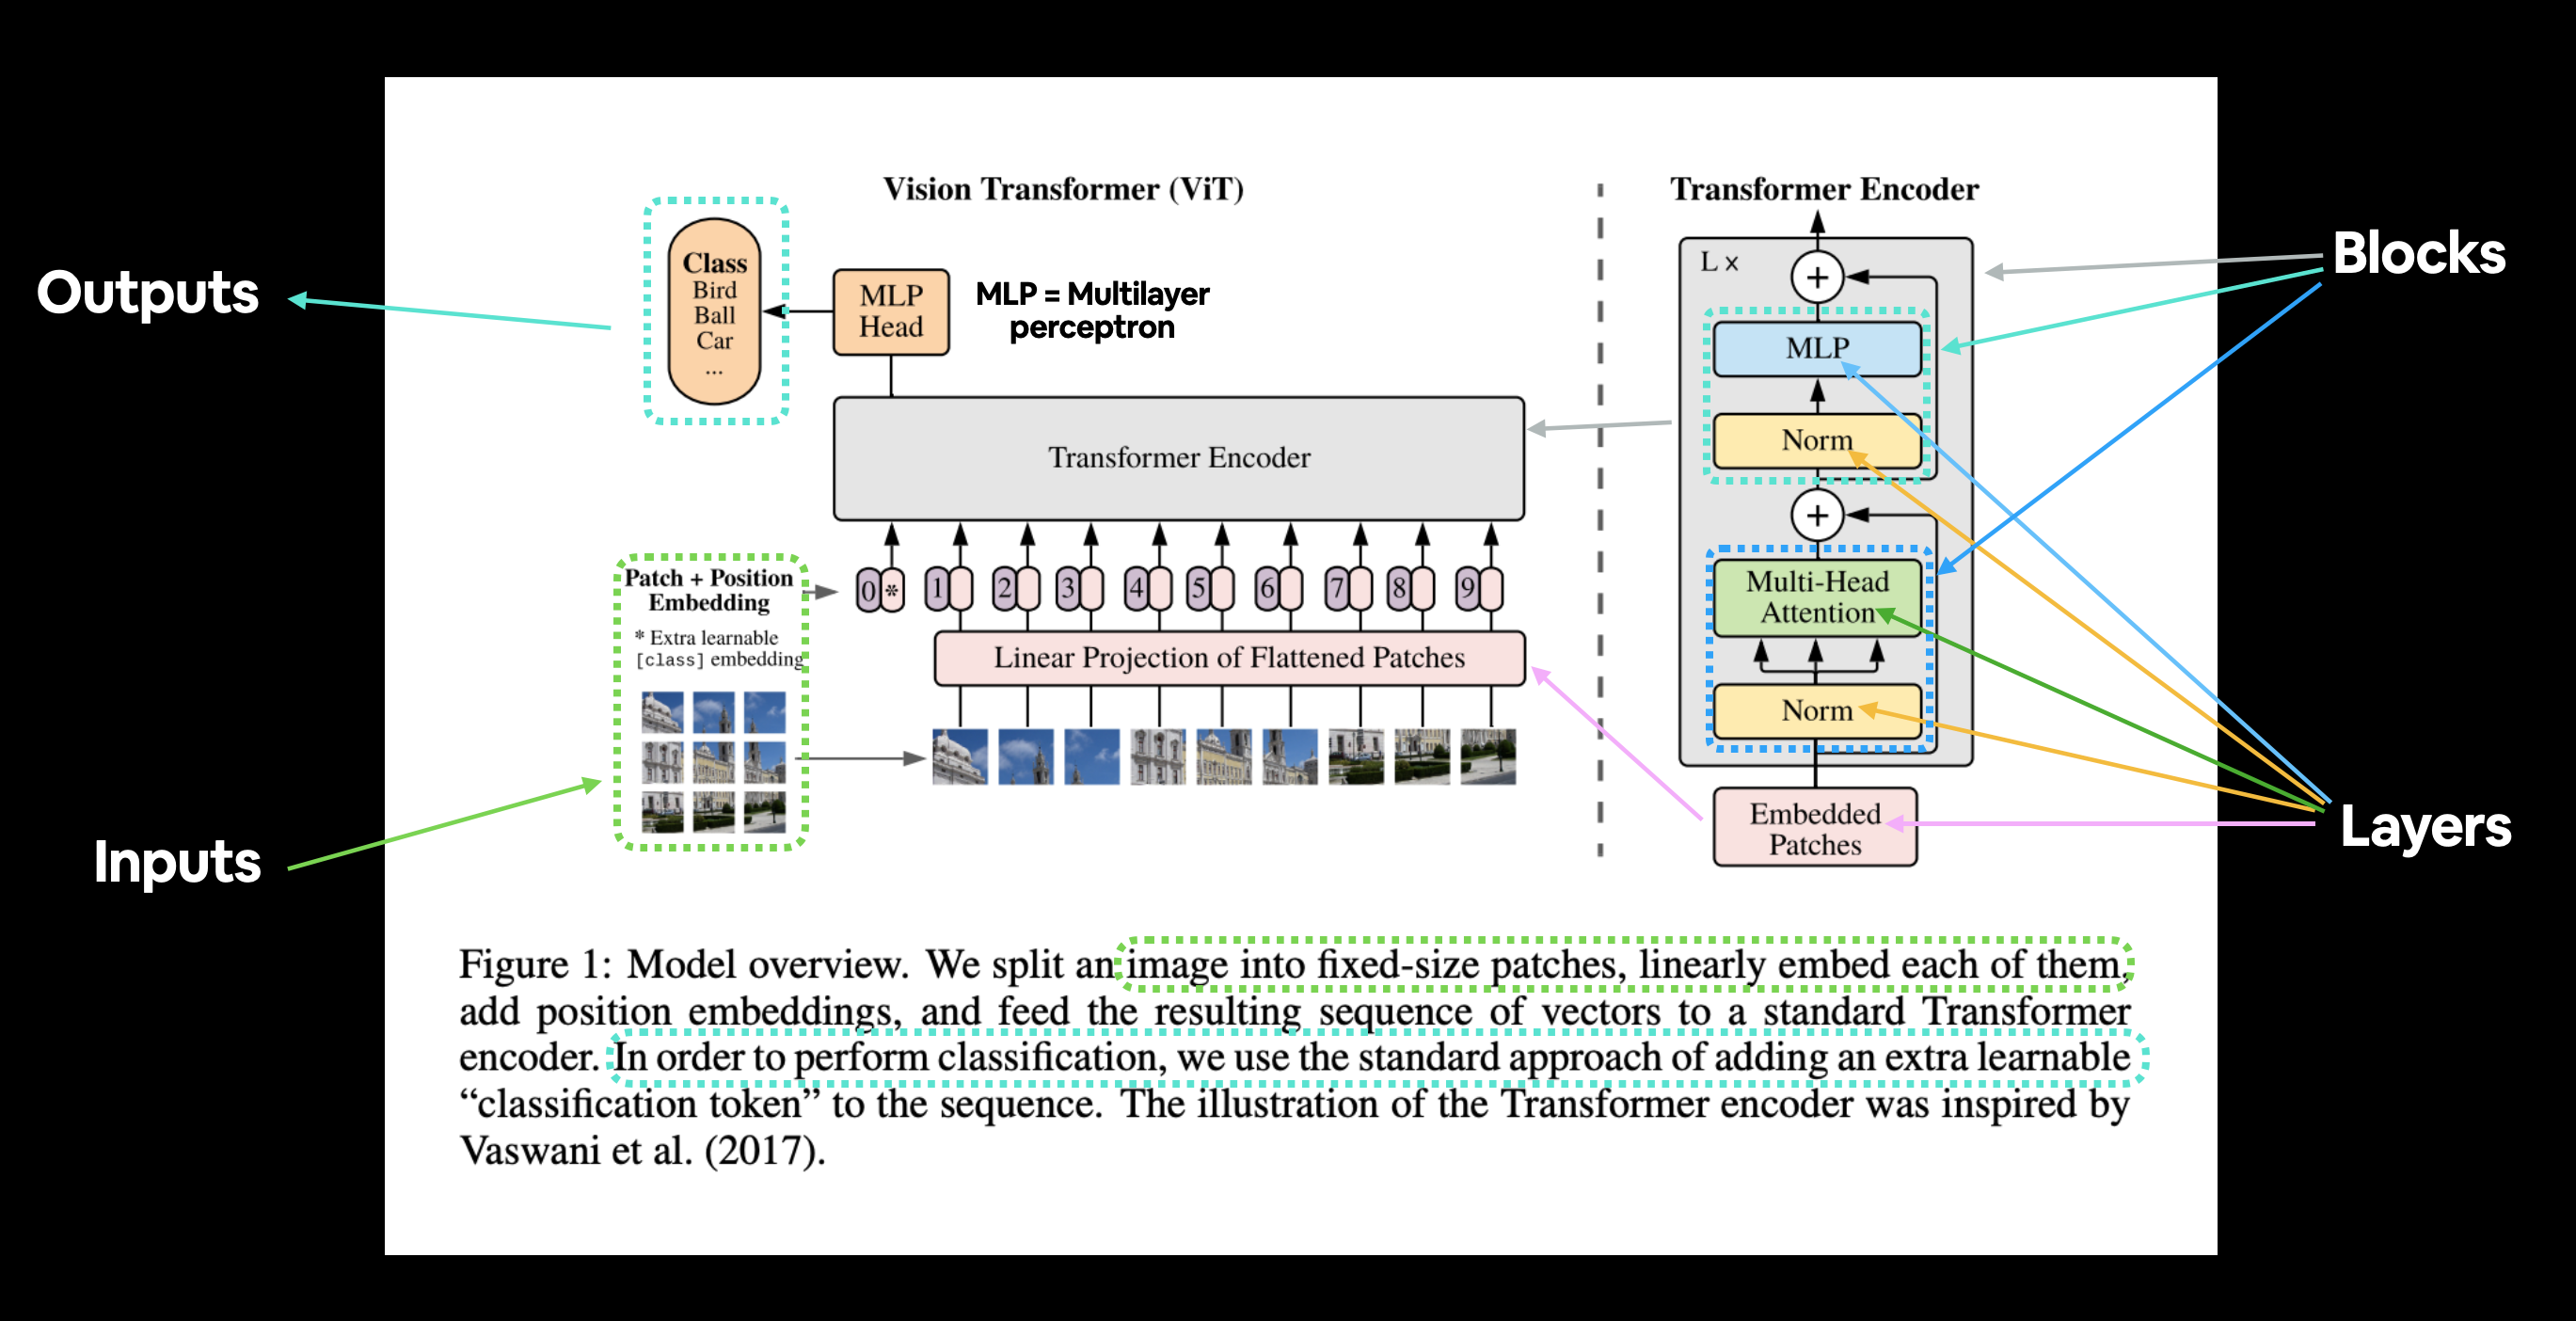

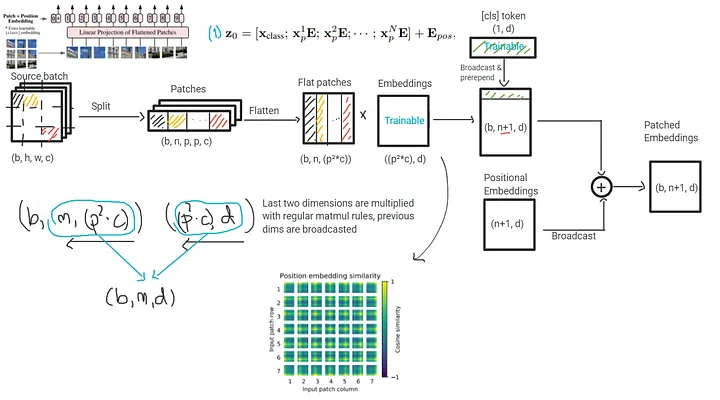

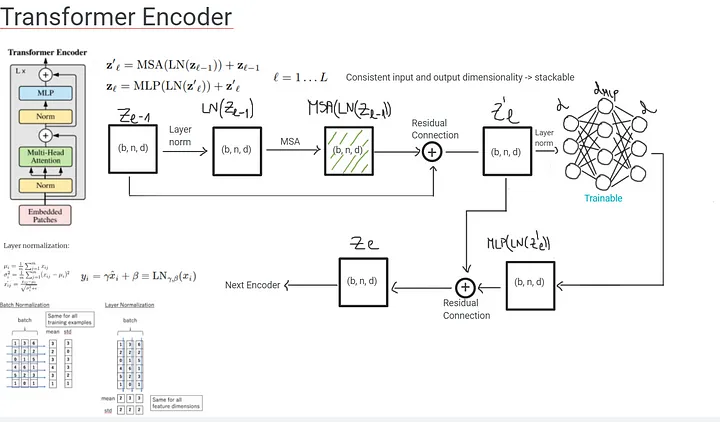


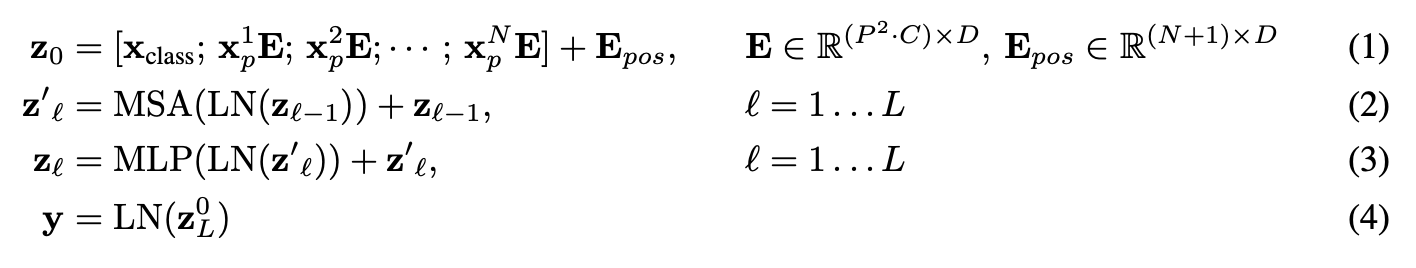



```
*   Layers - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
*   Hidden size - This is the embedding dimension throughout the architecture, this will be the size of the
    vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding
    dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.

*  MLP size - What are the number of hidden units in the MLP layers?

*   Heads - How many heads are there in the Multi-Head Attention layers?
*   Params - What are the total number of parameters of the model? Generally, more parameters leads to better
    performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters
    than any other model we've used so far.
```





# **Split data into patches class, position and patch embedding**

In [ ]:
# Input shape for patch embedding layer: (224, 224, 3)
# Output shape for patch embedding layer: (N, P^2 * C)
# P: patch size:
# N: no.of patches: (H*W) / P^2
# D: constant latent vector size: embedding dimension

height = 224
width = 224
color_channels =3
patch_size = 16     # img patches of size (16 x 16)

# Calculate no.of patches
number_of_patches = int((height*width) / patch_size**2)   # total no.of pixels / no.of pixels in a patch
number_of_patches

196

In [ ]:
# Input and output shapes of embedding layer
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, (patch_size**2) * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


# **Turn a single image to patches**

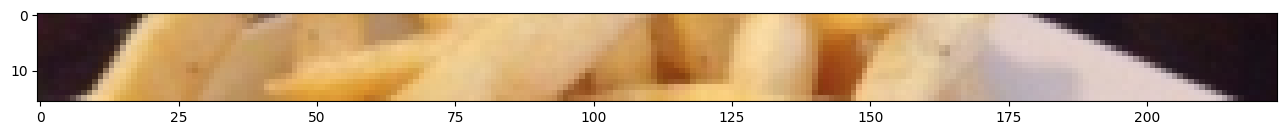

In [ ]:
image_permuted = image.permute(1, 2, 0)

plt.figure(figsize = (patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])        # (16, 224) entire width plotted
                          # H, W, C


Number of patches per row: 14.0


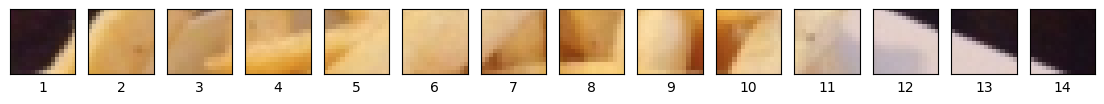

In [ ]:
# Turn the above top row to sequence of patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image not divisible by patch size"
print(f"Number of patches per row: {num_patches}")

# Create  subplots
fig, axs = plt.subplots(nrows = 1,
                        ncols = img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex = True,
                        sharey = True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
                                # H, W, C
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


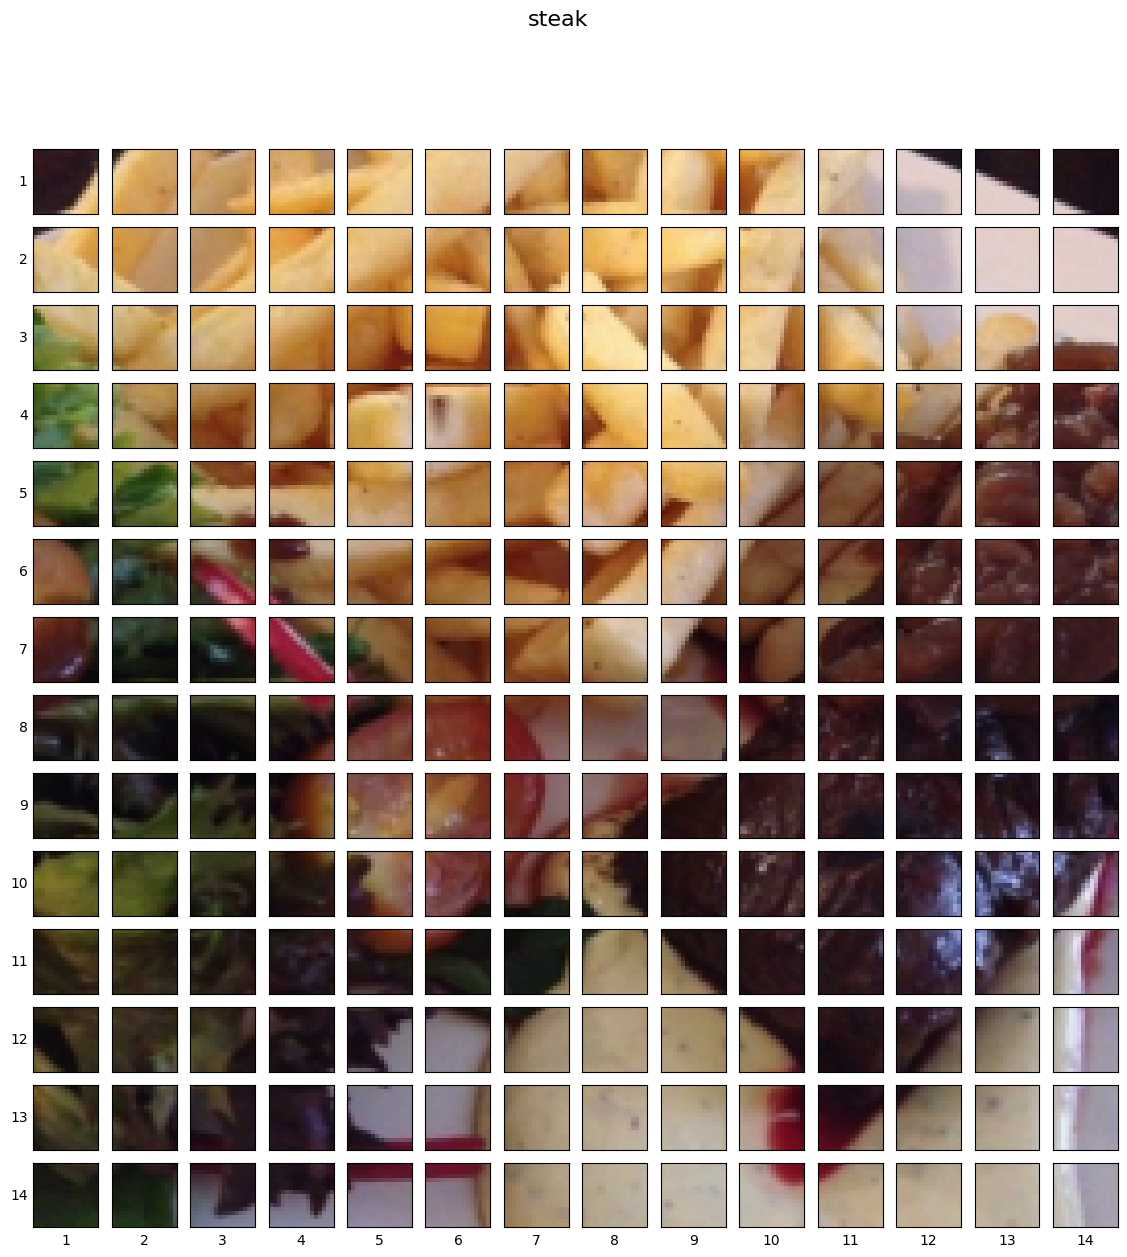

In [ ]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image not divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create subplots
fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols = img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex = True,
                        sharey = True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()


fig.suptitle(f"{class_names[label]}", fontsize=16)
plt.show()

# **Creating image patches and patch embedding**



```
Patches not created from sections of image, rather from convoluting across entire image to 768 channels (out_channels = 768)
```



In [ ]:
# Turn image into patch embeddings
# CNN convolutes accross entire image to create patches of 768, 196 such patches
# patches created from entire image, other way of implementing is to create patches from sections of image
from torch import nn

patch_size = 16
conv2d = nn.Conv2d(in_channels = 3, # RGB
                   out_channels = 768,   # embedding dim: D : (patch_size**2) * color_channels
                   kernel_size = (patch_size, patch_size),
                   stride = patch_size,
                   padding = 0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [ ]:
# Pass image through conv2d
image_out_of_conv = conv2d(image.unsqueeze(dim = 0))  # C, H, W
print(image_out_of_conv.shape)       # 14: H & W of feature map after CNN(patch_size = kernel_size = 16)
                                     # 14*14 = 196: no.of patches, total no.of pixels / no.of pixels in a patch
                                     # Batch, D(dimension of embedding), H_feature_map, W_feature_map
                                     # 14*14 = 196, flatten to 196 in further layer

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [37, 635, 51, 79, 628]


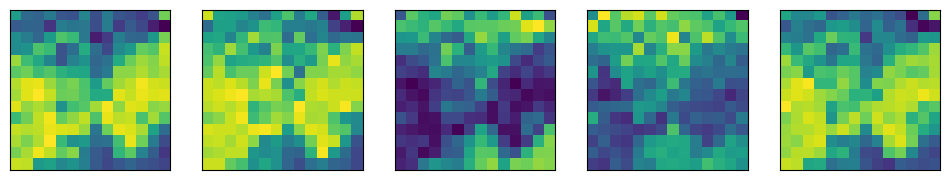

In [ ]:
import random
random_indexes = random.sample(range(0, 768 - 1), k=5) # 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
                                              # B, D(dim), H_feature_map, W_feature_map
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

# **Flattening the patch embedding**

In [ ]:
print(image_out_of_conv.shape)    # B, D(dim), H_feature_map, W_feature_map

torch.Size([1, 768, 14, 14])


In [ ]:
# Flattening the convolutional feature maps : [B, P (no_of_patches), D]

flatten = nn.Flatten(start_dim = 2, # flatten from dim 2 to 3 (count starts from 0)
                     end_dim = 3)

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")
print(f"Flattened image feature map shape after permute: {image_out_of_conv_flattened.permute(0, 2, 1).shape}")  # [B, P (no_of_patches), D]
# [1, 768, 196]  -> [1, 196, 768]   , 196: no.of features(pixels) in feature map
                                    # 786: embedding dim or out_channels

Flattened image feature map shape: torch.Size([1, 768, 196])
Flattened image feature map shape after permute: torch.Size([1, 196, 768])


In [ ]:
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)

# Get a single flattened feature map
single_flattened_feature_map  = image_out_of_conv_flattened_permuted[:, :, 0]  # embedding vector for 1 image
single_flattened_feature_map.shape

torch.Size([1, 196])

(-0.5, 195.5, 0.5, -0.5)

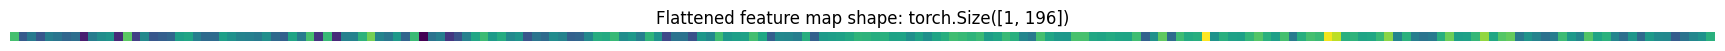

In [ ]:
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

# **Module to create patch embedding**

In [ ]:
# class patch embedding

class PatchEmbedding(nn.Module):
  def __init__(self, in_channels = 3, patch_size: int = 16,embedding_dim:int = 768):
    super().__init__()

    # Layer to turn an image to patch embedding
    self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)

    # Flatten feature map output from conv2d
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)

  def forward(self, x):
    image_resolution = x.shape[-1]  # H or W
    assert image_resolution % patch_size == 0, "Image size not divisible by patch size"

    x_flattened = self.flatten(self.patcher(x))

    return x_flattened.permute(0, 2, 1)  # [ batch, no_of_patches, embedding_dim ]

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))            # add batch dimension
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
patchify(rand_image_tensor).shape

torch.Size([1, 196, 768])

# **Learnable Class embedding**

```
state of class embedding at output of encoder serves as image representation

```



In [ ]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]
batch_size, embedding_dim

(1, 768)

In [ ]:
# Create class token embedding with same size as embedding dim
class_token = nn.Parameter( torch.ones(batch_size, 1, embedding_dim),  # B, no.of token, embedding_dim
                          requires_grad = True)                        # we are taking just one image B: 1


class_token.shape, patch_embedded_image.shape   # class token broadcasted across no.of patches(or no.of pixels in 1 feature map)

(torch.Size([1, 1, 768]), torch.Size([1, 196, 768]))

In [ ]:
# Add class tokens to patch embeddings
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim = 1)
patch_embedded_image_with_class_embedding.shape  # an addition dimension to "no.of patches" : 197 = 196(no.of patch embedding) + 1(class_token)

torch.Size([1, 197, 768])

# **Positional embedding**

```
1D learnable embeddings added to patch embeddings of tensor with class embeddiing
```



In [ ]:
# Calculate N (no.of patches)
number_of_patches = int((height * width) / patch_size**2)

# Embedding dimension: 768
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create learnable 1D postional embedding
positional_embedding = nn.Parameter( torch.ones(1, number_of_patches + 1, embedding_dim),   # additional 2nd dim as pe added after adding class token to tensor
                          requires_grad = True)
positional_embedding, positional_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [ ]:
# Add positional embedding to class and patch embeddings
patch_and_positional_embedding = patch_embedded_image_with_class_embedding + positional_embedding
patch_and_positional_embedding.shape  # we are taking just one image

torch.Size([1, 197, 768])

# **Image to embedding (Concat class_token & add PE)**

In [ ]:
# Equation 1
set_seeds()

patch_size = 16

height, width = image.shape[1], image.shape[2]

# Add batch dimsion
x = image.unsqueeze(dim = 0)
print(f"Original shape ater batch dim: {x.shape}")

# Create a patch embedding
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)
# Pass image through patch_embedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones( batch_size, 1, embedding_dim), requires_grad = True)
print(f"Class token shape: {class_token.shape}")

# Pretend class_tokens to patch_embedding
patch_embedded_image_with_class_token = torch.cat((class_token, patch_embedding), dim = 1)        #the tensors must either have the same shape,
                                                                                                  #except in the concatenating dimension, or be empty
print(f"Patch embedding with class token shape: {patch_embedded_image_with_class_token.shape}")

# Create positional embedding
number_of_patches = int((height * width) / patch_size**2)
positional_embedding = nn.Parameter( torch.ones(1, number_of_patches + 1, embedding_dim ), requires_grad = True)
print(f"Positional embedding shape: {positional_embedding.shape}")

# Add positional_embedding to patch embedding
patch_and_positional_embedding = patch_embedded_image_with_class_embedding + positional_embedding
print(f"Patch embedding with positional embedding shape: {patch_and_positional_embedding.shape}")

Original shape ater batch dim: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Positional embedding shape: torch.Size([1, 197, 768])
Patch embedding with positional embedding shape: torch.Size([1, 197, 768])


# **Multihead Self Attention**

In [ ]:
# Equation 2
# Layer normalization: noramlize distribution of intermediate layers. Enables faster training, smoother gradients, better generalization accuracy

class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, num_heads: int=12, attn_dropout: int=0):
    super().__init__()
    # Create layer norm
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)  # normalize across last dimension ( feature dim )

    # Create multi head attention
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True)  # (B, no_of_patches, embedding_dim)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_output

In [ ]:
multi_head_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim = 768, num_heads = 12, attn_dropout = 0)

# Pass the image embedding with PE through MSA block
patched_image_through_msa_block = multi_head_self_attention_block(patch_and_positional_embedding)
print(f"Input shape of MSA block: {patch_and_positional_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


# **MLP block**

```
Two layers with GELU contains dropout
```



In [ ]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim: int=768, mlp_size: int=3072, dropout: int=0.1):
    super().__init__()

    # Create the layer norm (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Create MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim)
    )

  def forward(self, x):
    return self.mlp(self.layer_norm(x))

In [ ]:
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# Pass output of the MSABlock through MLPBlock  (residual connection not implemented for now)
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


# **Encoder Block**

```
Encoder is an alternating combination of MSA & MLP bocks. Residual connection present between each block
```



In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, embedding_dim: int = 768,
               num_heads: int  = 12,
               mlp_size: int = 3072,
               mlp_dropout: int  = 0.1,
               attn_dropout: int  = 0):
    super().__init__()

    # Create MSA block eq: 2
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim = embedding_dim,
                                                num_heads = num_heads,
                                                attn_dropout = attn_dropout)

    # Create MLP block eq: 3
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)

  def forward(self, x):
    x = self.msa_block(x) + x  # residual connection for eq: 2
    x = self.mlp_block(x) + x  # residual connection for eq: 3
    return x

In [ ]:
transformer_encoder_block = TransformerEncoder()

# Getting encoder summary
summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),       # B, no_of_patches( + class_token), embedding_dim
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# **Creating ViT**

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,
               in_channels: int = 3,
               patch_size: int = 16,
               num_transformer_layer: int = 12,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               num_heads: int = 12,
               attn_dropout: int = 0,
               mlp_dropout: int = 0.1,
               embedding_dropout: int = 0.1,
               num_classes: int = 1000
               ):
    super().__init__()
    assert img_size % patch_size == 0, "Image dim not disible by patch size"

    # Calculate no.of patches
    self.num_patches = (img_size**2) // patch_size**2

    # Learnable patch embedding, conact to front of patch embedding
    self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                        requires_grad = True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches + 1, embedding_dim),
                                          requires_grad = True)
    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p = embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                          patch_size = patch_size,
                                          embedding_dim = embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim = embedding_dim,
                                                                  num_heads = num_heads,
                                                                  mlp_size = mlp_size,
                                                                  mlp_dropout = mlp_dropout) for _ in range(num_transformer_layer)])

    # Create classifer head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )

  def forward(self, x):
    # Get batch size
    batch_size = x.shape[0]

    # Create class toke, expand across all dimensions
    class_token = self.class_embedding.expand(batch_size, -1, -1) # (1, 1, 768)  -> (B, 1, 768)
                                                                      # expand() method repeats the tensor along a dimension to match the specified shape
    # Create patch embedding eq: 1
    x = self.patch_embedding(x)

    # Concat class tokens to patch embedding
    x = torch.cat((class_token, x), dim = 1) #the tensors must either have the same shape, except in the concatenating dimension, or be empty

    # Add PE
    x = self.position_embedding + x

    # Apply dropout to patch embedding
    x = self.embedding_dropout(x)

    # Pass positional & patch embedding to  Transformer Encoder  eq: 2 & 3
    x = self.transformer_encoder(x)

    # Pass 0th index logit thrugh classifier
    x = self.classifier(x[:, 0]) # Across all batches

    return x

In [ ]:
vit = ViT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit = vit.to(device)
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerEncoder(
      (msa_block): Mult

In [ ]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224).to(device)

vit = ViT(num_classes = len(class_names))
vit = vit.to(device)

print(f"Device of random_image_tensor: {random_image_tensor.device}")
print(f"Device of vit: {next(vit.parameters()).device}")

vit(random_image_tensor).shape

Device of random_image_tensor: cuda:0
Device of vit: cuda:0


torch.Size([1, 3])

In [ ]:
# Getting ViT summary
summary(model = vit,
        input_size = (1, 3, 224, 224),       # B, no_of_patches( + class_token), embedding_dim
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        device = device,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoder (0)                                [1, 197, 768]        [1, 197, 768] 

# **Training ViT model**

In [ ]:
# Loss and Optimizer
# Weight decay: regularization technique, prevent model weights from getting too large by adding penalities to loss_fn if weights get large

optimizer = torch.optim.Adam(vit.parameters(), lr = 0.001, betas = (0.9, 0.999), weight_decay = 0.1)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from going_modular.going_modular import engine
set_seeds()
results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       epochs = 20,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       device = device
                       )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3013 | train_acc: 0.3594 | test_loss: 2.0630 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.4074 | train_acc: 0.4102 | test_loss: 2.0013 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4470 | train_acc: 0.2891 | test_loss: 1.6601 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2549 | train_acc: 0.4062 | test_loss: 1.7582 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.2371 | train_acc: 0.3047 | test_loss: 1.1164 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1885 | train_acc: 0.3047 | test_loss: 1.0467 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1113 | train_acc: 0.2852 | test_loss: 1.1979 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1516 | train_acc: 0.2930 | test_loss: 1.1349 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1465 | train_acc: 0.3164 | test_loss: 1.0936 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1423 | train_acc: 0.4219 | test_loss: 1.1850 | test_acc: 0.2604
Epoch: 11 | train_loss: 1.1539 | train_acc: 0.2969 | test_loss: 1.0496 | test_acc: 0.5417
Epoch: 12 | train_l

# **Plot Loss curves**

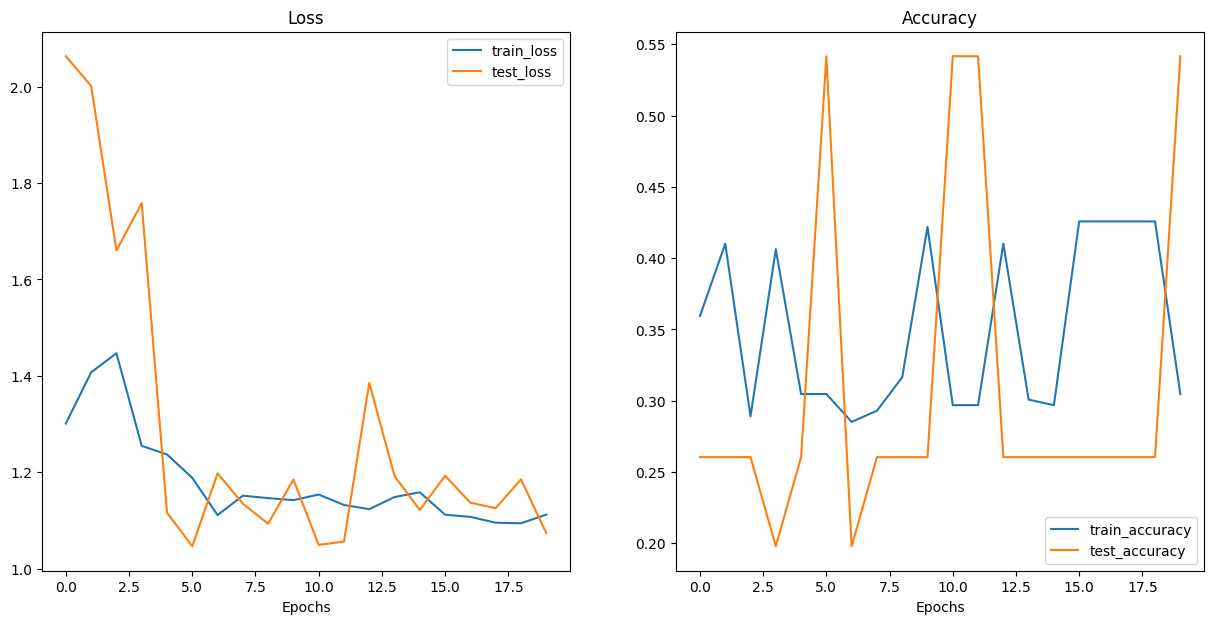

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

# **Using a pretrained ViT**

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 57.6MB/s]


In [ ]:
summary(model = pretrained_vit,
         input_size = (32, 3, 224, 224), # (batch_size, color_channels, height, width)
         col_names = ["input_size"],
         col_names = ["input_size", "output_size", "num_params", "trainable"],
         col_width = 20,
         row_settings = ["var_names"]
 )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Get what transformes was done to the ViT from pytorch
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [ ]:
# Train and test model

from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


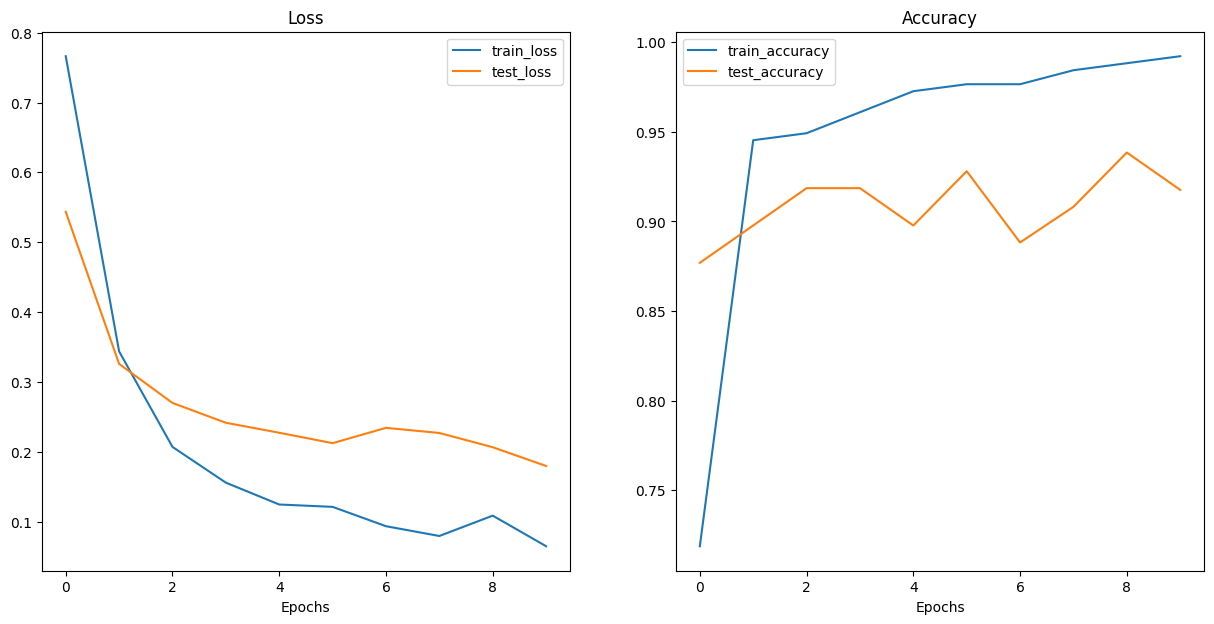

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)